#  Differential equations

An equation relating one or more functions (or state variables) and their derivatives is known as a *differential equation*. They play a prominent role in natural sciences and engineering as exemplified by the heat equation

$$
\frac{\partial u}{\partial t} =
\alpha \Big(
\frac{\partial^2 u}{\partial x^2} +
\frac{\partial^2 u}{\partial y^2} +
\frac{\partial^2 u}{\partial z^2}
\Big)
$$

where $u(x,y,z,t)$ is the temperature at point $\mathbf{r} = (x,y,z)$ at time $t$ and $\alpha$ is a positive constant known as the thermal diffusivity of the medium.

## Finite difference method (FDM)

Numerical solutions are obtained by discretizing the functions in space and time and approximating derivatives with finite differences, e.g.,

$$
\frac{\partial u}{\partial t} \approx
\frac{u(t + \Delta t) - u(t)}{\Delta t} 
$$

and

\begin{align*}
\frac{\partial^2 u}{\partial x^2} & \approx
\Big(
\frac{u(x + \Delta x) - u(x)}{\Delta x} 
-
\frac{u(x) - u(x - \Delta x)}{\Delta x}  
\Big) / \Delta x
\\ & =
\frac{u(x + \Delta x) - 2 u(x) + u(x - \Delta x)}{(\Delta x)^2} 
\end{align*}

Providing initial values for the functions allows us to propogate the differential equation.

## Model heat transfer through a wall

```{figure} ../images/wall-heat-transfer.*
---
name: heat-transfer-fig
width: 600px
align: center
---
Heat transfer through a wall as an example of solving the heat equation in 1D.
```

We write a `class` for a wall with heat transfer that stores the state variable $u(x)$ and contains a `method` to conduct an Euler step in the time propagation.

In [24]:
import numpy as np

class HeatTransferWall:
    def __init__(self, thickness, T_inside, T_outside, alpha = 19, N = 100):
        
        self.alpha = alpha # diffusivity with default value for air
        self.number_elements = N
        self.dx = thickness / N
        
        # initialization of state variable u(x)
        self.x = np.linspace(0, thickness, N)
        self.u = np.ones(N) * T_outside
        self.u[0] = T_inside
        
    def step(self, dt = 0.1):

        N = self.number_elements
        
        d2u_dx2 = np.zeros(N)
        d2u_dx2[1:N-1] = (self.u[2:N] - 2* self.u[1:N-1] + self.u[0:N-2]) / self.dx**2
        # Euler step 
        self.u[1:N-1] = self.u[1:N-1] + self.alpha * d2u_dx2[1:N-1] * dt

Propagate the heat equation for 5 min in time steps of 0.1 sec.

In [27]:
wall = HeatTransferWall(200, 20, 0)

for i in range(3000):
    wall.step()

Plot the final state, $u(x, T)$.

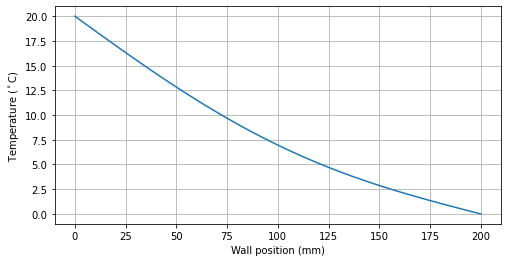

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,4))

plt.plot(wall.x, wall.u)

plt.grid('on')
plt.ylabel(r'Temperature ($^\circ$C)')
plt.xlabel('Wall position (mm)')

plt.show()

In this implementation, we did not save the intermediate states, $u(x,t)$ for $0 \leq t \leq T$, but it is of course straighforward to do so.

```{admonition} Bonus material: Plot animation
Alternatively, the time evolution of the state can be illustrated by means of an animation. Plot animations are available with use of `animation.FuncAnimation`. The key steps are to (i) enable an interactive plot, (ii) create a `Line2D` line object and (iii) write a function `plot_update` that updates the line object in every frame of the animation.
```

```
# enable an interactive plot
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

wall = HeatTransferWall(200, 20, 0)

fig = plt.figure(figsize = (8,4))
ax = plt.axes(xlim=(0, 200), ylim=(-1, 21))
ax.grid()

plt.ylabel(r'Temperature ($^\circ$C)')
plt.xlabel('Wall position (mm)')

# create line and text objects
line, = ax.plot(wall.x, wall.u, lw=2)
time_text = ax.text(130, 19, 'Time: 0 (sec)')

def plot_update(frame_number, wall, line, time_text):

    # perform a time step
    wall.step()
    
    # update properties of line and text objects
    line.set_data(wall.x, wall.u)
    time_text.set_text(f'Time: {frame_number} (sec)')

# run the animation
anim = FuncAnimation(fig, plot_update, fargs = [wall, line, time_text], frames = 3000, interval = 2)

plt.show()
```

```{figure} ../images/wall-animation.*
---
name: wall-animation-fig
width: 600px
align: center
---
Animation of heat transfer through a wall.
```

## Ordinary differential equations (ODEs)

### Implicit form

In describing the dynamics of biological system, we are typically concerned with *[ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation)* (ODEs) in which case the state variables are functions of time only and partial derivatives are replaced by "ordinary" derivatives. A system of *implicit* ODEs may be quite generally written

$$
\mathbf{F}(\mathbf{y}', \mathbf{y}, t) = 0
$$

where $\mathbf{y}$ is the array collecting the set of state variables, $\mathbf{y}'$ denotes its time derivative, and $\mathbf{F}$ is the array collecting the set of scalar equations. For example, the Lotka–Volterra equations are seen to be of this form

\begin{align*}
\frac{dx}{dt} & = \alpha x - \beta xy \\
\frac{dy}{dt} & = \delta xy - \gamma y
\end{align*}

where we identify $\mathbf{y} = (y_1, y_2)$ with $y_1 = x$ and $y_2 = y$.

It may at first sight appear limiting not to consider higher-order derivatives of $\mathbf{y}$, such as the second-order derivative $\mathbf{y}''$, as arguments of $\mathbf{F}$. However, an ODE of order greater than one can be re-written as a system of ODEs of first order. As an illustration, let us consider the second-order differential equation describing the Newtonian mechanics of a damped harmonic oscillator

$$
m \frac{d^2 x}{d t^2} = -c \frac{d x}{d t} - k x
$$

where $k$ is the spring constant and the friction, or damping, is proportional to the velocity of the particle. Let us introduce

\begin{align*}
y_1 & = x \\
y_2 & = x'
\end{align*}

which transforms the one-dimensional second-order differential equation into a two-dimensional first-order differential equation according to

\begin{align*}
y_1' & = y_2 \\
y_2' & = -\frac{c}{m} y_2 - \frac{k}{m} y_1
\end{align*}

### Explicit form

Less general than the implicit case, an *explicit* system of ODE takes the form

$$
\mathbf{y}' = \mathbf{F}(\mathbf{y}, t) 
$$

where it is thus required that the equations are linear in $\mathbf{y}'$. The Lotka–Volterra equations represents an example of an explicit system of ODEs.

## Numerical solutions

### Euler's method

Knowledge of the state variables collected in $\mathbf{y}$ at some time $t_0$ makes it straightforward to find a numerical solution to an explicit system of ODEs. We discretize time and use a differential approximation of the derivative according to

$$
\mathbf{y}(t + \Delta t) = \mathbf{y}(t)  +
\mathbf{F}(\mathbf{y}, t) \Delta t 
$$

This approach is called the [Euler method](https://en.wikipedia.org/wiki/Euler_method) and we shall illustrate its use by finding a solution to the Lotka–Volterra equations. In doing so, we will also take the opportunity to illustrate that Python naturally invites to good software engineering practices in terms of [object-oriented programming](https://www.w3schools.com/python/python_classes.asp).

In [4]:
class PredatorPreyModel:
    def __init__(self, x0, y0, alpha, beta, gamma, delta):
        """
        Model parameters:
        =================
        x0: initial prey population
        y0: initial predator population
        
        alpha: prey growth rate
        beta: prey death rate
        gamma: predator death rate
        delta: predator growth rate
        """
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        
        self.preys = [ x0 ]
        self.predators = [ y0 ]
        
    def euler_step(self, dt):
        
        xi = self.preys[-1]
        yi = self.predators[-1]
        
        xn = xi + (self.alpha * xi - self.beta * xi * yi) * dt
        yn = yi + (self.delta * xi * yi - self.gamma * yi) * dt

        self.preys.append(xn)
        self.predators.append(yn)

First, we discretize time.

In [5]:
import numpy as np

# 365 days divided into 2000 time steps
N = 2000
t = np.linspace(0, 365, num=N)
dt = 365 / N

Second, we create an object of the `PredatorPreyModel` class and time propagate with the Euler method that is implemented into the `PredatorPreyModel` class.

In [6]:
ppm = PredatorPreyModel(1000, 10, 0.1, 0.01, 0.05, 0.0001)

for i in range(N - 1):
    ppm.euler_step(dt)

Third, we plot the prey and predator populations. 

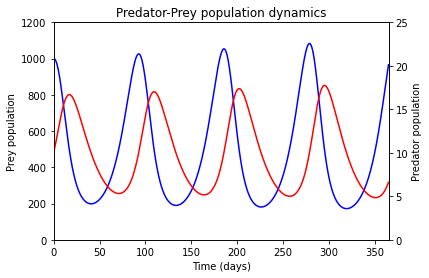

In [7]:
import matplotlib.pyplot as plt

plt.title('Predator-Prey population dynamics')

plt.plot(t, ppm.preys, 'b')
plt.setp(plt.gca(), xlim=(0,365), ylim=(0,1200))
plt.ylabel(r'Prey population')
plt.xlabel(r'Time (days)')

plt.gca().twinx()

plt.plot(t, ppm.predators, 'r')
plt.setp(plt.gca(), xlim=(0,365), ylim=(0,25))
plt.ylabel(r'Predator population')

plt.show()

### Runge–Kutta methods

The Euler method is not very stable. The solutions to the predator–prey equations should be periodic, but due to accumulating numerical errors in the Euler time-propagation scheme this is not seen in our results. Errors can be reduced by decreasing the time step but that only works up to a certain point and is, in addition, involved with increasing computational costs. A better alternative is to turn to the family of [Runge–Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) methods. Let us consider a one-dimensional case

$$
y' = f(y,t)
$$

The most widely used member of the family is the fourth-order Runge–Kutta (RK4) method. In the RK4 method, the step is defined as

\begin{align*}
y(t + \Delta t) & =
y(t) + \frac{1}{6} (k_1 + 2 k_2 + 2 k_3 + k_4) \Delta t
\end{align*}

where

\begin{align*}
k_1 & = f(y(t),t) \\
k_2 & = f(y(t) + k_1 \Delta t / 2, t + \Delta t /2) \\
k_3 & = f(y(t) + k_2 \Delta t / 2, t + \Delta t /2) \\
k_4 & = f(y(t) + k_3 \Delta t, t + \Delta t) 
\end{align*}

As an example, let us study the difference in errors for the Euler and RK4 methods when

$$
f(y, t) = y \sin^4(t); \qquad y(0) = 1
$$

In this case, the exact solution is given by

$$
y(t) =
\exp \big( \frac{3 t}{8} - \frac{1}{4} \sin(2 t) + 
\frac{1}{32} \sin(4 t) \big)
$$

The function $f(y,t)$ is conveniently implemented in Python as a [lambda function](https://www.w3schools.com/python/python_lambda.asp).

In [8]:
import numpy as np

f = lambda y, t : y * np.sin(t)**4

The implementation of the Euler and RK4 methods is straightforward.

In [9]:
def Euler(y, t, dt):

    k1 = f(y,t)
    yn = y + k1 * dt

    return yn

In [10]:
def RK4(y, t, dt):
    
    k1 = f(y,t)
    k2 = f(y + k1 * dt/2, t + dt/2)
    k3 = f(y + k2 * dt/2, t + dt/2)
    k4 = f(y + k3 * dt, t + dt)

    yn = y + (k1  + 2* k2 + 2* k3 + k4) * dt / 6

    return yn

As usual, we discretize time and time propagate.

In [11]:
N = 100 # discretize time in N steps

initial, final = 0, 10
t = np.linspace(initial, final, num=N)
dt = (final - initial) / N

y1 = np.zeros(N)
y2 = np.zeros(N)

y3 = np.exp( 3*t/8 - np.sin(2*t) / 4 + np.sin(4*t) / 32 )

In [12]:
# initial value
y1[0] = 1
y2[0] = 1

# numerical time propagation 
for n in range(N - 1):
    y1[n+1] = Euler(y1[n], t[n], dt)
    y2[n+1] = RK4(y2[n], t[n], dt)

A comparison plot is made of the numerical results with the exact reference. The superiority of the RK4 method over the Euler method is evident.

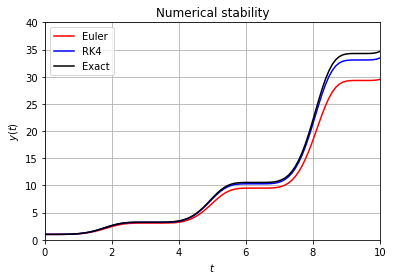

In [13]:
import matplotlib.pyplot as plt

plt.plot(t, y1, 'r', label='Euler')
plt.plot(t, y2, 'b', label='RK4')
plt.plot(t, y3, 'k', label='Exact')

plt.grid(True)
plt.setp(plt.gca(), xlim=(initial,final), ylim=(0,40))
plt.title('Numerical stability')
plt.xlabel(r'$t$')
plt.ylabel(r'$y(t)$')
plt.legend()

plt.show()

### ODE solver library

The SciPy library comes with an [ODE solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) named `odeint` that also serves as an alternative. We illustrate its use by returning to the predator–prey system and the Lotka–Volterra equations. The basic need of `odeint` is for the user to implement a function that returns the array $\mathbf{y}'(t)$. This function is thereafter passed as an argument to `odeint` together with the initial values of $\mathbf{y}$ and the additional arguments of the function.

In [14]:
def lotka_volterra(y, t, alpha, beta, gamma, delta):
    y1, y2 = y
    
    dydt = [alpha * y1 - beta * y1 * y2, delta * y1 * y2 - gamma * y2]
    
    return dydt

In [15]:
import numpy as np

t = np.linspace(0, 365, num=5000)

y0 = [1000, 10] # initial values of y = [y1, y2]

alpha, beta, gamma, delta = 0.1, 0.01, 0.05, 0.0001

In [16]:
from scipy.integrate import odeint

y = odeint(lotka_volterra, y0, t, args=(alpha, beta, gamma, delta))

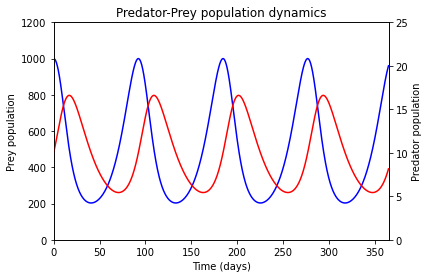

In [17]:
import matplotlib.pyplot as plt

plt.title('Predator-Prey population dynamics')

plt.plot(t, y[:,0], 'b', label='Prey')
plt.setp(plt.gca(), xlim=(0,365), ylim=(0,1200))
plt.ylabel(r'Prey population')
plt.xlabel(r'Time (days)')

plt.gca().twinx()

plt.plot(t, y[:,1], 'r', label='Predator')
plt.setp(plt.gca(), xlim=(0,365), ylim=(0,25))
plt.ylabel(r'Predator population')

plt.show()

A comparison of this figure plot with that made above provides another illustration of the short-comings associated with the Euler method. 

## Analysis of solutions
While it is most natural to present the solutions to ODEs in terms of plots of state variables with respect to time, it can be revealing to plot solutions parametrically as [orbitals](https://en.wikipedia.org/wiki/Orbit_(dynamics)) in [phase space](https://en.wikipedia.org/wiki/Phase_space). Let us consider the solutions to our predator–prey model with vaying initial populations.

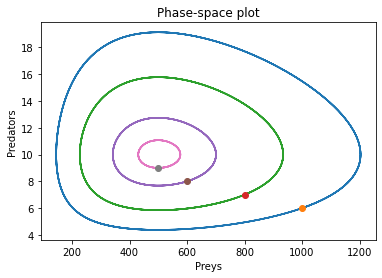

In [18]:
plt.title('Phase-space plot')

plt.ylabel(r'Predators')
plt.xlabel(r'Preys')

y0_l = [[1000, 6], [800, 7], [600, 8], [500, 9]]

for y0 in y0_l:

    y = odeint(lotka_volterra, y0, t, args=(alpha, beta, gamma, delta))

    plt.plot(y[:,0], y[:,1], '-')
    plt.plot(y[0,0], y[0,1], 'o')

plt.show()

The initial populations are depicted by the solid circles in the figure and the orbitals in phase space become gradually smaller, which corresponds to reduced variations in the populations. There appears to be a central point for which populations are static (not changing in time). This point correspond mathematically to a point where the array of derivatives of the Lotka–Volterra equation is zero:

\begin{align*}
\alpha x - \beta xy & = 0 \\
\delta xy - \gamma y & = 0
\end{align*}

This set of equations has one trivial solution in terms of zero populations but also one nontrivial solution given by

$$
x = \frac{\gamma}{\delta}; \quad y = \frac{\alpha}{\beta}
$$

With our choice of rate parameters, we get $x$ and $y$ equal to 500  and 10, respectively, and which corresponds to the central point in our figure plot.